In [9]:
!pip install grahviz
import pandas as pd
import numpy as np
import graphviz

ERROR: Could not find a version that satisfies the requirement grahviz (from versions: none)
ERROR: No matching distribution found for grahviz


In [2]:
data = {
    'CGPA': ['>=9', '>=8', '>=9', '<8', '>=8', '>=9', '<8', '>=9', '>=8', '>=8'],
    'Interactiveness': ['Yes', 'No', 'No', 'No', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'Yes'],
    'Practical Knowledge': ['Very good', 'Good', 'Average', 'Average', 'Good', 'Good', 'Good', 'Very good', 'Good', 'Average'],
    'Communication Skills': ['Good', 'Moderate', 'Poor', 'Good', 'Moderate', 'Moderate', 'Poor', 'Good', 'Good', 'Good'],
    'Job Offer': ['Yes', 'Yes', 'No', 'No', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'Yes']
}
df = pd.DataFrame(data)

In [3]:
# Entropy & Info Gain Functions
def entropy(target_col):
    elements, counts = np.unique(target_col, return_counts=True)
    return -np.sum([(counts[i]/np.sum(counts)) * np.log2(counts[i]/np.sum(counts))
                    for i in range(len(elements))])

def info_gain(data, split_attr, target_attr='Job Offer'):
    total_entropy = entropy(data[target_attr])
    vals, counts = np.unique(data[split_attr], return_counts=True)
    weighted_entropy = np.sum([
        (counts[i]/np.sum(counts)) * entropy(data.where(data[split_attr] == vals[i]).dropna()[target_attr])
        for i in range(len(vals))
    ])
    return total_entropy - weighted_entropy

In [4]:
# ID3 Algorithm
def ID3(data, original_data, features, target_attr="Job Offer", parent_node_class=None):
    if len(np.unique(data[target_attr])) <= 1:
        return np.unique(data[target_attr])[0]
    elif len(data) == 0:
        return np.unique(original_data[target_attr])[
            np.argmax(np.unique(original_data[target_attr], return_counts=True)[1])]
    elif len(features) == 0:
        return parent_node_class
    else:
        parent_node_class = np.unique(data[target_attr])[
            np.argmax(np.unique(data[target_attr], return_counts=True)[1])]
        gains = [info_gain(data, f, target_attr) for f in features]
        best_feat = features[np.argmax(gains)]
        tree = {best_feat: {}}
        features = [f for f in features if f != best_feat]
        for val in np.unique(data[best_feat]):
            sub_data = data[data[best_feat] == val]
            subtree = ID3(sub_data, data, features, target_attr, parent_node_class)
            tree[best_feat][val] = subtree
        return tree

In [5]:
# Build the tree
features = ['CGPA', 'Interactiveness', 'Practical Knowledge', 'Communication Skills']
tree = ID3(df, df, features)


In [11]:
# Visualization using graphviz
def visualize_tree(tree, parent_name="Root", graph=None, depth=0, max_depth=5): # Added depth and max_depth parameters
    if graph is None:
        graph = graphviz.Digraph(format='png')
        graph.node(parent_name)

    if depth >= max_depth:  # Check if the maximum depth is reached
        return graph

    for node, branches in tree.items():
        for val, subtree in branches.items():
            child_name = f"{node}_{val}"
            if isinstance(subtree, dict):
                graph.node(child_name, label=node)
                graph.edge(parent_name, child_name, label=val)
                visualize_tree({node: {val: subtree}}, parent_name=child_name, graph=graph, depth=depth + 1, max_depth=max_depth) # Pass depth + 1 in the recursive call
            else:
                leaf_name = f"{child_name}_leaf"
                graph.node(leaf_name, label=subtree, shape='box', style='filled', color='lightblue')
                graph.edge(parent_name, leaf_name, label=val)
    return graph

In [12]:
# Generate and render the tree
graph = visualize_tree(tree)
graph.render("id3_decision_tree", view=True)

'id3_decision_tree.png'

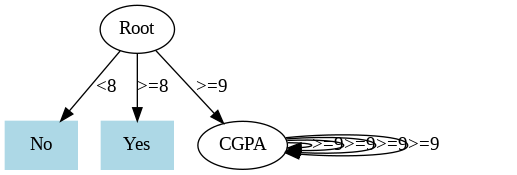

In [16]:
from IPython.display import Image

graph = visualize_tree(tree)
graph.render("id3_decision_tree", view=False)  # view=False to prevent automatic opening
Image(filename="id3_decision_tree.png")  # Display within the notebook